# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os
from torchvision.utils import make_grid

## load data

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

real            = torch.from_numpy(data['real_images']).float()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## hyper-parameters

In [3]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 150
size_minibatch  = 50
dim_latent      = 50
dim_channel     = 1
learning_rate_discriminator = 0.001
learning_rate_generator     = 0.001

In [4]:
import random
def affine(image, shear=0, scale=1, rate=[10, 10]):

    func_plt = transforms.functional.to_pil_image
    func_affine = transforms.functional.affine
    func_tensor = transforms.functional.to_tensor

    for i in range(len(image)):

        # random movement
        if rate[0] != 0:
            rate_1 = np.random.randint(-rate[0], rate[0]+1)
            rate_2 = np.random.randint(-rate[1], rate[1]+1)
            movement = [rate_1, rate_2]
        else:
            movement = rate

        if isinstance(scale, list):
            rescale = np.random.randint(scale[0], scale[1]+1) / 10
        else:
            rescale = scale


        trans_image = func_plt(image[i])
        trans_image = func_affine(trans_image, angle=0, shear=shear, scale=rescale, translate=movement)
        trans_image = func_tensor(trans_image)
        trans_image = trans_image.numpy()

        if i == 0:
            image_list = trans_image
        else:
            image_list = np.concatenate([image_list, trans_image], axis=0)

    return image_list

In [5]:
real_image = real[::2]
affine_12 = affine(real_image, scale=[10, 12], rate=[0, 0])
affine_random = affine(real_image, scale=1, rate=[3, 3])

## custom data loader for the PyTorch framework

In [6]:
class dataset (Dataset):
    def  __init__(self, data):

        self.data = data

    def __getitem__(self, index):

        data = self.data[index]
        data = torch.FloatTensor(data).unsqueeze(dim=0)

        return data
  
    def __len__(self):
        
        return self.data.shape[0]

## construct datasets and dataloaders for training and testing

In [7]:
# image_train = np.concatenate([real[1::2], affine_12, affine_random], axis=0)
dataset_real    = dataset(real)
dataloader_real = DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

In [8]:
# image_train.shape

## shape of the data when using the data loader

In [9]:
image_real = dataset_real[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_real.shape)
print('*******************************************************************')

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 32, 32])
*******************************************************************


## class for the neural network 

In [10]:
class Discriminator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=128):
        
		super(Discriminator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2
		
		self.feature = nn.Sequential(
			# ================================================================================
			nn.Conv2d(in_channel, dim_feature * 1, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 1, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 2, dim_feature * 4, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 4, dim_feature * 8, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 8, dim_feature * 16, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
		)	
		
		self.classifier = nn.Sequential(
			# ================================================================================
			nn.Linear(dim_feature * 16, dim_feature * 8, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 8, dim_feature * 4, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 4, dim_feature * 2, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 2, dim_feature * 1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 1, out_channel, bias=True),
			# ================================================================================
		) 

		self.network = nn.Sequential(
			self.feature,
			nn.Flatten(),
			self.classifier,
		)

		self.initialize_weight()

		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		y = self.network.forward(x)

		return y

	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass

In [11]:
class Generator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=8):
        
		super(Generator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2

		self.network = nn.Sequential(
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(in_channel, dim_feature * 8, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 8),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 8, dim_feature * 4, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 4),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 4, dim_feature * 2, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 2),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 2, dim_feature * 1, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 1),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 1, out_channel, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(out_channel),
			# ================================================================================
			nn.Sigmoid(),
			# ================================================================================
		) 			

		# self.initialize_weight()
		
		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		y = self.network.forward(x)

		return y

	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass


## build network

In [12]:
generator       = Generator(dim_latent, 1, 128).to(device)
discriminator   = Discriminator(dim_channel, 1, 128).to(device)

optimizer_generator     = torch.optim.Adam(generator.parameters(), lr=learning_rate_generator, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_discriminator, betas=(0.5, 0.999))

initialize model parameters : xavier_uniform


## compute the prediction

In [13]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [14]:
def compute_loss_discriminator(generator, discriminator, latent, data_real):

    data_fake       = compute_prediction(generator, latent)
    prediction_real = compute_prediction(discriminator, data_real)
    prediction_fake = compute_prediction(discriminator, data_fake)

    criterion   = nn.BCEWithLogitsLoss()
    
    label_real  = torch.ones_like(prediction_real)
    label_fake  = torch.zeros_like(prediction_fake)

    # ==================================================
    # fill up the blank
    #    
    loss_real = criterion(prediction_real, label_real)
    loss_fake = criterion(prediction_fake, label_fake)
    # 
    # ==================================================

    loss_discriminator = (loss_real + loss_fake) / 2.0

    return loss_discriminator

In [15]:
def compute_loss_generator(generator, discriminator, latent):

    data_fake       = compute_prediction(generator, latent)
    prediction_fake = compute_prediction(discriminator, data_fake)

    criterion       = nn.BCEWithLogitsLoss()

    label_real      = torch.ones_like(prediction_fake)

    # ==================================================
    # fill up the blank
    #    
    loss_generator  = criterion(prediction_fake, label_real)
    # 
    # ==================================================

    return loss_generator

## compute the accuracy

In [16]:
def get_center_index(binary_image):
    
    area_square = np.sum(binary_image)

    height = binary_image.shape[0]
    width = binary_image.shape[1]

    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    indices_X, indices_Y = np.meshgrid(x, y)

    x_mean = np.sum(binary_image * indices_X) / area_square
    y_mean = np.sum(binary_image * indices_Y) / area_square

    return (x_mean, y_mean)

In [17]:
# create ideal square image which has the same area to the input image
def create_label(binary_images):
    
    label = np.zeros_like(binary_images)
    
    for i, binary_image in enumerate(binary_images):
        
        image_height = binary_image.shape[0]
        image_width = binary_image.shape[1]

        square_image = np.zeros((image_height, image_width))
        square_length = np.round(np.sqrt(np.sum(binary_image)))

        if square_length == 0:
            # when there is no square
            return square_image

        (square_center_x, square_center_y) = get_center_index(binary_image)

        if square_center_x < 0 or square_center_x > image_width - 1 or square_center_y < 0 or square_center_y > image_height - 1:
            return square_image

        top = np.ceil(square_center_y - square_length / 2)
        bottom = np.floor(square_center_y + square_length / 2)
        left = np.ceil(square_center_x - square_length / 2)
        right = np.floor(square_center_x + square_length / 2)

        top = int(top) if top >= 0 else 0
        bottom = int(bottom) if bottom <= image_height - 1 else image_height - 1
        left = int(left) if left >= 0 else 0
        right = int(right) if right <= image_width - 1 else image_width - 1

        square_image[top : bottom + 1, left : right + 1] = 1
        
        label[i] = square_image
        
    return label

In [18]:
def compute_accuracy(prediction):

    prediction  = prediction.squeeze(axis=1)
    
    prediction_binary   = (prediction >= 0.5).cpu().numpy().astype(int)
    label               = create_label(prediction_binary).astype(int)
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [19]:
loss_generator_mean     = np.zeros(number_epoch)
loss_generator_std      = np.zeros(number_epoch)
loss_discriminator_mean = np.zeros(number_epoch)
loss_discriminator_std  = np.zeros(number_epoch)

accuracy_mean   = np.zeros(number_epoch)
accuracy_std    = np.zeros(number_epoch)

## train

In [20]:
def train(generator, discriminator, dataloader):

    loss_epoch_generator      = []
    loss_epoch_discriminator  = []
    accuracy_epoch = []
    
    for index_batch, data_real in enumerate(dataloader):

        size_batch  = len(data_real)
        data_real   = data_real.to(device)
        
        latent  = torch.randn(size_batch, dim_latent, device=device)
        latent  = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()

        optimizer_generator.zero_grad()
        loss_generator = compute_loss_generator(generator, discriminator, latent)
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()

        optimizer_discriminator.zero_grad()
        loss_discriminator = compute_loss_discriminator(generator, discriminator, latent, data_real)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        data_fake   = compute_prediction(generator, latent)
        accuracy    = compute_accuracy(data_fake)

        loss_epoch_generator.append(loss_generator.item())
        loss_epoch_discriminator.append(loss_discriminator.item())
        accuracy_epoch.append(accuracy)

    loss_generator_mean_epoch       = np.mean(loss_epoch_generator)
    loss_generator_std_epoch        = np.std(loss_epoch_generator)
    
    loss_discriminator_mean_epoch   = np.mean(loss_epoch_discriminator)
    loss_discriminator_std_epoch    = np.std(loss_epoch_discriminator)

    accuracy_mean_epoch             = np.mean(accuracy_epoch)
    accuracy_std_epoch              = np.std(accuracy_epoch)

    loss_value_generator        = {'mean' : loss_generator_mean_epoch, 'std' : loss_generator_std_epoch}
    loss_value_discriminator    = {'mean' : loss_discriminator_mean_epoch, 'std' : loss_discriminator_std_epoch}
    accuracy_value              = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch} 

    return loss_value_generator, loss_value_discriminator, accuracy_value


## training epoch

In [21]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_value_generator, loss_value_discriminator, accuracy_value) = train(generator, discriminator, dataloader_real)

    loss_generator_mean[i]      = loss_value_generator['mean']
    loss_generator_std[i]       = loss_value_generator['std']

    loss_discriminator_mean[i]  = loss_value_discriminator['mean']
    loss_discriminator_std[i]   = loss_value_discriminator['std']

    accuracy_mean[i]            = accuracy_value['mean']
    accuracy_std[i]             = accuracy_value['std']

    print(f"epoch : {i}")
    print(f"\tloss_value_discriminator : {loss_value_discriminator['mean']}, acc mean : {accuracy_value['mean']}")

  1%|          | 1/150 [00:17<43:24, 17.48s/it]

epoch : 0
	loss_value_discriminator : 8.72911584862443, acc mean : 68.76511695934664


  1%|▏         | 2/150 [00:34<43:02, 17.45s/it]

epoch : 1
	loss_value_discriminator : 0.8505695586980775, acc mean : 70.43305550021303


  2%|▏         | 3/150 [00:52<42:46, 17.46s/it]

epoch : 2
	loss_value_discriminator : 0.7152452891649201, acc mean : 57.608057526719314


  3%|▎         | 4/150 [01:09<42:27, 17.45s/it]

epoch : 3
	loss_value_discriminator : 0.7277896574070287, acc mean : 27.796360153021887


  3%|▎         | 5/150 [01:27<41:58, 17.37s/it]

epoch : 4
	loss_value_discriminator : 0.6349864394165748, acc mean : 36.549332556550716


  4%|▍         | 6/150 [01:43<41:18, 17.21s/it]

epoch : 5
	loss_value_discriminator : 3257715.24699654, acc mean : 9.369022874483631


  5%|▍         | 7/150 [02:01<41:05, 17.24s/it]

epoch : 6
	loss_value_discriminator : 237335.3203429067, acc mean : 47.89438911854447


  5%|▌         | 8/150 [02:18<40:31, 17.12s/it]

epoch : 7
	loss_value_discriminator : 641.7482366035151, acc mean : 9.043999411885778


  6%|▌         | 9/150 [02:34<39:55, 16.99s/it]

epoch : 8
	loss_value_discriminator : 33.64931702876507, acc mean : 0.0


  7%|▋         | 10/150 [02:51<39:23, 16.88s/it]

epoch : 9
	loss_value_discriminator : 20.58052222448033, acc mean : 0.0


  7%|▋         | 11/150 [03:08<38:53, 16.79s/it]

epoch : 10
	loss_value_discriminator : 15.035176531476683, acc mean : 0.0


  8%|▊         | 12/150 [03:24<38:27, 16.72s/it]

epoch : 11
	loss_value_discriminator : 75.61130885246187, acc mean : 0.0


  9%|▊         | 13/150 [03:41<38:03, 16.67s/it]

epoch : 12
	loss_value_discriminator : 98.65419797369209, acc mean : 0.0


  9%|▉         | 14/150 [03:57<37:41, 16.63s/it]

epoch : 13
	loss_value_discriminator : 29.856061666035203, acc mean : 0.0


 10%|█         | 15/150 [04:14<37:19, 16.59s/it]

epoch : 14
	loss_value_discriminator : 153.18797269660632, acc mean : 0.0


 11%|█         | 16/150 [04:30<36:59, 16.56s/it]

epoch : 15
	loss_value_discriminator : 35.93407874243897, acc mean : 0.0


 11%|█▏        | 17/150 [04:47<36:40, 16.55s/it]

epoch : 16
	loss_value_discriminator : 135.88409245083497, acc mean : 0.0


 12%|█▏        | 18/150 [05:03<36:22, 16.54s/it]

epoch : 17
	loss_value_discriminator : 272.4715221143046, acc mean : 0.0


 13%|█▎        | 19/150 [05:20<36:05, 16.53s/it]

epoch : 18
	loss_value_discriminator : 18.363118225165785, acc mean : 0.0


 13%|█▎        | 20/150 [05:36<35:48, 16.52s/it]

epoch : 19
	loss_value_discriminator : 10.84164838238711, acc mean : 0.0


 14%|█▍        | 21/150 [05:53<35:31, 16.52s/it]

epoch : 20
	loss_value_discriminator : 257.6139462895602, acc mean : 0.0


 15%|█▍        | 22/150 [06:09<35:15, 16.53s/it]

epoch : 21
	loss_value_discriminator : 90.22497041779029, acc mean : 0.0


 15%|█▌        | 23/150 [06:26<34:59, 16.53s/it]

epoch : 22
	loss_value_discriminator : 3.5687619153258585, acc mean : 0.0


 16%|█▌        | 24/150 [06:42<34:43, 16.53s/it]

epoch : 23
	loss_value_discriminator : 30.97641328789922, acc mean : 0.0


 17%|█▋        | 25/150 [06:59<34:28, 16.55s/it]

epoch : 24
	loss_value_discriminator : 1.0903482882377453, acc mean : 0.0


 17%|█▋        | 26/150 [07:15<34:12, 16.55s/it]

epoch : 25
	loss_value_discriminator : 14.650725272130394, acc mean : 0.0


 18%|█▊        | 27/150 [07:32<33:56, 16.56s/it]

epoch : 26
	loss_value_discriminator : 2.89743140432345, acc mean : 0.8964425137585331


 19%|█▊        | 28/150 [07:49<33:42, 16.58s/it]

epoch : 27
	loss_value_discriminator : 0.7561627463604287, acc mean : 0.0


 19%|█▉        | 29/150 [08:05<33:25, 16.57s/it]

epoch : 28
	loss_value_discriminator : 2.0718652382372644, acc mean : 0.0


 20%|██        | 30/150 [08:22<33:09, 16.58s/it]

epoch : 29
	loss_value_discriminator : 0.5156541855610213, acc mean : 0.0


 21%|██        | 31/150 [08:39<32:55, 16.60s/it]

epoch : 30
	loss_value_discriminator : 132.19484495798298, acc mean : 0.0


 21%|██▏       | 32/150 [08:56<32:55, 16.74s/it]

epoch : 31
	loss_value_discriminator : 1006.9425382078733, acc mean : 24.140004927741586


 22%|██▏       | 33/150 [09:12<32:36, 16.73s/it]

epoch : 32
	loss_value_discriminator : 26.403207103897103, acc mean : 2.932010975483275


 23%|██▎       | 34/150 [09:29<32:18, 16.71s/it]

epoch : 33
	loss_value_discriminator : 7.221181774714983, acc mean : 0.0


 23%|██▎       | 35/150 [09:46<32:02, 16.71s/it]

epoch : 34
	loss_value_discriminator : 5.686468864249629, acc mean : 1.4839209458695977


 24%|██▍       | 36/150 [10:03<31:51, 16.77s/it]

epoch : 35
	loss_value_discriminator : 4.982350031411448, acc mean : 8.624424753893956


 25%|██▍       | 37/150 [10:19<31:35, 16.77s/it]

epoch : 36
	loss_value_discriminator : 1.398177186246788, acc mean : 3.2328475370529595


 25%|██▌       | 38/150 [10:36<31:23, 16.82s/it]

epoch : 37
	loss_value_discriminator : 88.27774907163409, acc mean : 14.950786250311038


 26%|██▌       | 39/150 [10:53<30:59, 16.75s/it]

epoch : 38
	loss_value_discriminator : 1.9026495731172766, acc mean : 0.0


 27%|██▋       | 40/150 [11:09<30:37, 16.71s/it]

epoch : 39
	loss_value_discriminator : 5.287627990509188, acc mean : 0.0


 27%|██▋       | 41/150 [11:27<30:35, 16.84s/it]

epoch : 40
	loss_value_discriminator : 1378.19421163799, acc mean : 30.549314606674344


 28%|██▊       | 42/150 [11:43<30:19, 16.84s/it]

epoch : 41
	loss_value_discriminator : 17.809142632259952, acc mean : 3.806813273144172


 29%|██▊       | 43/150 [12:00<30:06, 16.88s/it]

epoch : 42
	loss_value_discriminator : 4.724745358744986, acc mean : 13.238983677754605


 29%|██▉       | 44/150 [12:18<30:00, 16.98s/it]

epoch : 43
	loss_value_discriminator : 10.849838531608839, acc mean : 35.50606562541757


 30%|███       | 45/150 [12:35<29:48, 17.03s/it]

epoch : 44
	loss_value_discriminator : 3.022119397616121, acc mean : 21.845078422837314


 31%|███       | 46/150 [12:52<29:34, 17.06s/it]

epoch : 45
	loss_value_discriminator : 0.14946570403354112, acc mean : 23.012391434530855


 31%|███▏      | 47/150 [13:09<29:27, 17.16s/it]

epoch : 46
	loss_value_discriminator : 0.4274805273080981, acc mean : 43.89385331879437


 32%|███▏      | 48/150 [13:27<29:20, 17.26s/it]

epoch : 47
	loss_value_discriminator : 0.9275306244527137, acc mean : 48.819919901778356


 33%|███▎      | 49/150 [13:44<29:09, 17.32s/it]

epoch : 48
	loss_value_discriminator : 0.5814102678884601, acc mean : 47.267168068435645


 33%|███▎      | 50/150 [14:02<28:56, 17.37s/it]

epoch : 49
	loss_value_discriminator : 0.9293326938588485, acc mean : 47.28787148737295


 34%|███▍      | 51/150 [14:19<28:42, 17.39s/it]

epoch : 50
	loss_value_discriminator : 0.24221950984268237, acc mean : 46.84094586795598


 35%|███▍      | 52/150 [14:37<28:24, 17.39s/it]

epoch : 51
	loss_value_discriminator : 1667.4512851661166, acc mean : 41.038611431440636


 35%|███▌      | 53/150 [14:54<28:05, 17.37s/it]

epoch : 52
	loss_value_discriminator : 99.22502896363636, acc mean : 40.79045786265039


 36%|███▌      | 54/150 [15:11<27:50, 17.40s/it]

epoch : 53
	loss_value_discriminator : 2.6866229235833328, acc mean : 45.82296554085875


 37%|███▋      | 55/150 [15:29<27:34, 17.42s/it]

epoch : 54
	loss_value_discriminator : 0.7550382508040836, acc mean : 44.058567096948195


 37%|███▋      | 56/150 [15:46<27:18, 17.43s/it]

epoch : 55
	loss_value_discriminator : 2.5257712111942414, acc mean : 42.77257407991519


 38%|███▊      | 57/150 [16:04<27:02, 17.45s/it]

epoch : 56
	loss_value_discriminator : 0.4380951189893423, acc mean : 44.27401926440364


 39%|███▊      | 58/150 [16:21<26:45, 17.45s/it]

epoch : 57
	loss_value_discriminator : 0.1690978256699859, acc mean : 44.25104547633065


 39%|███▉      | 59/150 [16:39<26:28, 17.45s/it]

epoch : 58
	loss_value_discriminator : 23.326287640846257, acc mean : 44.42259349105328


 40%|████      | 60/150 [16:56<26:11, 17.46s/it]

epoch : 59
	loss_value_discriminator : 7.2358558933698, acc mean : 43.67634037810995


 41%|████      | 61/150 [17:14<25:53, 17.46s/it]

epoch : 60
	loss_value_discriminator : 0.09075459307631448, acc mean : 45.66695961095084


 41%|████▏     | 62/150 [17:31<25:36, 17.46s/it]

epoch : 61
	loss_value_discriminator : 26.88977083262506, acc mean : 47.11834105475784


 42%|████▏     | 63/150 [17:49<25:19, 17.46s/it]

epoch : 62
	loss_value_discriminator : 23.13051304091333, acc mean : 44.140678932194874


 43%|████▎     | 64/150 [18:06<25:02, 17.47s/it]

epoch : 63
	loss_value_discriminator : 0.06757120086182748, acc mean : 47.995150052821565


 43%|████▎     | 65/150 [18:23<24:43, 17.46s/it]

epoch : 64
	loss_value_discriminator : 0.04188240007129172, acc mean : 50.41870227278813


 44%|████▍     | 66/150 [18:41<24:26, 17.46s/it]

epoch : 65
	loss_value_discriminator : 0.022308803816422033, acc mean : 50.35523823522525


 45%|████▍     | 67/150 [18:58<24:09, 17.46s/it]

epoch : 66
	loss_value_discriminator : 0.09382792690709277, acc mean : 51.069055120067986


 45%|████▌     | 68/150 [19:16<23:51, 17.46s/it]

epoch : 67
	loss_value_discriminator : 434.8061294389048, acc mean : 50.609522078463065


 46%|████▌     | 69/150 [19:33<23:34, 17.46s/it]

epoch : 68
	loss_value_discriminator : 8.303632069931313, acc mean : 48.72368680094659


 47%|████▋     | 70/150 [19:51<23:17, 17.46s/it]

epoch : 69
	loss_value_discriminator : 1.0690981762340155, acc mean : 48.62649446825567


 47%|████▋     | 71/150 [20:08<22:59, 17.47s/it]

epoch : 70
	loss_value_discriminator : 0.3498793559478119, acc mean : 47.965656964647415


 48%|████▊     | 72/150 [20:26<22:41, 17.46s/it]

epoch : 71
	loss_value_discriminator : 0.037672784651973636, acc mean : 49.00443656026605


 49%|████▊     | 73/150 [20:43<22:24, 17.46s/it]

epoch : 72
	loss_value_discriminator : 0.04498260685154148, acc mean : 48.71843108437238


 49%|████▉     | 74/150 [21:01<22:07, 17.47s/it]

epoch : 73
	loss_value_discriminator : 0.008880656582436874, acc mean : 50.02895525187237


 50%|█████     | 75/150 [21:18<21:50, 17.47s/it]

epoch : 74
	loss_value_discriminator : 0.011344152286397296, acc mean : 49.10974031666973


 51%|█████     | 76/150 [21:36<21:32, 17.46s/it]

epoch : 75
	loss_value_discriminator : 0.0, acc mean : 50.01137374719171


 51%|█████▏    | 77/150 [21:53<21:14, 17.46s/it]

epoch : 76
	loss_value_discriminator : 1106.7184042585409, acc mean : 48.5562649047778


 52%|█████▏    | 78/150 [22:10<20:49, 17.35s/it]

epoch : 77
	loss_value_discriminator : 45881768.280922465, acc mean : 27.348473045085182


 53%|█████▎    | 79/150 [22:28<20:34, 17.39s/it]

epoch : 78
	loss_value_discriminator : 11379.789203732513, acc mean : 62.77777519188573


 53%|█████▎    | 80/150 [22:45<20:09, 17.28s/it]

epoch : 79
	loss_value_discriminator : 57263.02380343076, acc mean : 19.28432757343689


 54%|█████▍    | 81/150 [23:01<19:41, 17.12s/it]

epoch : 80
	loss_value_discriminator : 5620.9759172838785, acc mean : 2.4264523852669133


 55%|█████▍    | 82/150 [23:18<19:13, 16.97s/it]

epoch : 81
	loss_value_discriminator : 1097.1218697498011, acc mean : 0.7999418829965966


 55%|█████▌    | 83/150 [23:35<18:49, 16.86s/it]

epoch : 82
	loss_value_discriminator : 4728.6999761087945, acc mean : 0.0


 56%|█████▌    | 84/150 [23:51<18:26, 16.77s/it]

epoch : 83
	loss_value_discriminator : 374.1891685363858, acc mean : 0.0


 57%|█████▋    | 85/150 [24:08<18:05, 16.71s/it]

epoch : 84
	loss_value_discriminator : 16916.431000545967, acc mean : 0.0


 57%|█████▋    | 86/150 [24:24<17:47, 16.68s/it]

epoch : 85
	loss_value_discriminator : 587.0041147719982, acc mean : 1.6977552163790492


 58%|█████▊    | 87/150 [24:42<17:43, 16.88s/it]

epoch : 86
	loss_value_discriminator : 348.10627727193196, acc mean : 52.09067423551949


 59%|█████▊    | 88/150 [24:59<17:37, 17.05s/it]

epoch : 87
	loss_value_discriminator : 214.03965163785358, acc mean : 65.66807029437344


 59%|█████▉    | 89/150 [25:17<17:26, 17.16s/it]

epoch : 88
	loss_value_discriminator : 65.9019656014997, acc mean : 67.55054044965047


 60%|██████    | 90/150 [25:34<17:15, 17.25s/it]

epoch : 89
	loss_value_discriminator : 27.64006974426813, acc mean : 68.84983661835706


 61%|██████    | 91/150 [25:51<17:01, 17.31s/it]

epoch : 90
	loss_value_discriminator : 9.446139831875646, acc mean : 69.26483714539128


 61%|██████▏   | 92/150 [26:09<16:46, 17.36s/it]

epoch : 91
	loss_value_discriminator : 4.231874507527019, acc mean : 70.56642354509435


 62%|██████▏   | 93/150 [26:26<16:31, 17.39s/it]

epoch : 92
	loss_value_discriminator : 1.965680626935737, acc mean : 71.41559088590755


 63%|██████▎   | 94/150 [26:44<16:14, 17.41s/it]

epoch : 93
	loss_value_discriminator : 1.9301352556361708, acc mean : 72.9162629381578


 63%|██████▎   | 95/150 [27:01<15:58, 17.42s/it]

epoch : 94
	loss_value_discriminator : 2.70436429977417, acc mean : 73.96052362026238


 64%|██████▍   | 96/150 [27:19<15:41, 17.44s/it]

epoch : 95
	loss_value_discriminator : 3.553975770639819, acc mean : 74.84238767831962


 65%|██████▍   | 97/150 [27:36<15:24, 17.45s/it]

epoch : 96
	loss_value_discriminator : 2.5923812999281775, acc mean : 75.23643609527134


 65%|██████▌   | 98/150 [27:54<15:07, 17.46s/it]

epoch : 97
	loss_value_discriminator : 4.181034423048765, acc mean : 75.48161093708183


 66%|██████▌   | 99/150 [28:11<14:50, 17.46s/it]

epoch : 98
	loss_value_discriminator : 20.43843492241793, acc mean : 75.13073808841403


 67%|██████▋   | 100/150 [28:29<14:33, 17.46s/it]

epoch : 99
	loss_value_discriminator : 5.503695754117744, acc mean : 74.31802114774128


 67%|██████▋   | 101/150 [28:46<14:15, 17.47s/it]

epoch : 100
	loss_value_discriminator : 0.3607335783714472, acc mean : 73.6569727224055


 68%|██████▊   | 102/150 [29:04<13:58, 17.46s/it]

epoch : 101
	loss_value_discriminator : 0.0, acc mean : 73.35479498799647


 69%|██████▊   | 103/150 [29:21<13:40, 17.46s/it]

epoch : 102
	loss_value_discriminator : 0.0, acc mean : 73.3401862874184


 69%|██████▉   | 104/150 [29:39<13:23, 17.46s/it]

epoch : 103
	loss_value_discriminator : 0.0, acc mean : 73.26807985778063


 70%|███████   | 105/150 [29:56<13:06, 17.47s/it]

epoch : 104
	loss_value_discriminator : 0.3072506549746491, acc mean : 73.13760823528517


 71%|███████   | 106/150 [30:13<12:48, 17.47s/it]

epoch : 105
	loss_value_discriminator : 2.4070539474487305, acc mean : 73.22802948087383


 71%|███████▏  | 107/150 [30:31<12:31, 17.47s/it]

epoch : 106
	loss_value_discriminator : 3.7399064219275187, acc mean : 73.14606096022429


 72%|███████▏  | 108/150 [30:48<12:13, 17.47s/it]

epoch : 107
	loss_value_discriminator : 0.5282453520353451, acc mean : 72.60002468040952


 73%|███████▎  | 109/150 [31:06<11:56, 17.47s/it]

epoch : 108
	loss_value_discriminator : 9.00244252626286, acc mean : 70.93412105769744


 73%|███████▎  | 110/150 [31:23<11:39, 17.48s/it]

epoch : 109
	loss_value_discriminator : 20.84326485145924, acc mean : 70.31779065016082


 74%|███████▍  | 111/150 [31:41<11:21, 17.47s/it]

epoch : 110
	loss_value_discriminator : 5.172856619191724, acc mean : 69.3239612682724


 75%|███████▍  | 112/150 [31:58<11:03, 17.47s/it]

epoch : 111
	loss_value_discriminator : 3.6137171734211058, acc mean : 69.62170918344209


 75%|███████▌  | 113/150 [32:16<10:46, 17.47s/it]

epoch : 112
	loss_value_discriminator : 51450.36986191606, acc mean : 61.697101919639216


 76%|███████▌  | 114/150 [32:33<10:29, 17.48s/it]

epoch : 113
	loss_value_discriminator : 489.60654253322025, acc mean : 35.23389914685997


 77%|███████▋  | 115/150 [32:51<10:11, 17.48s/it]

epoch : 114
	loss_value_discriminator : 308.3043426711892, acc mean : 36.98852704423854


 77%|███████▋  | 116/150 [33:08<09:54, 17.48s/it]

epoch : 115
	loss_value_discriminator : 252.7612970318905, acc mean : 40.186655693822175


 78%|███████▊  | 117/150 [33:26<09:36, 17.46s/it]

epoch : 116
	loss_value_discriminator : 51.86968441284803, acc mean : 43.35120569169258


 79%|███████▊  | 118/150 [33:43<09:18, 17.47s/it]

epoch : 117
	loss_value_discriminator : 23.364133858982864, acc mean : 45.94650725531742


 79%|███████▉  | 119/150 [34:01<09:01, 17.47s/it]

epoch : 118
	loss_value_discriminator : 5.367223501205444, acc mean : 47.308656279179836


 80%|████████  | 120/150 [34:18<08:44, 17.47s/it]

epoch : 119
	loss_value_discriminator : 10.718686272931654, acc mean : 49.32143099008213


 81%|████████  | 121/150 [34:36<08:26, 17.48s/it]

epoch : 120
	loss_value_discriminator : 2.2465504047482514, acc mean : 50.21562350406032


 81%|████████▏ | 122/150 [34:53<08:09, 17.47s/it]

epoch : 121
	loss_value_discriminator : 1.926835112793501, acc mean : 50.592029495872


 82%|████████▏ | 123/150 [35:10<07:51, 17.46s/it]

epoch : 122
	loss_value_discriminator : 1.6288935417352721, acc mean : 51.02215422606607


 83%|████████▎ | 124/150 [35:28<07:34, 17.46s/it]

epoch : 123
	loss_value_discriminator : 0.20053058446839797, acc mean : 51.09541491375205


 83%|████████▎ | 125/150 [35:45<07:16, 17.47s/it]

epoch : 124
	loss_value_discriminator : 0.0, acc mean : 51.404985667046034


 84%|████████▍ | 126/150 [36:03<06:59, 17.46s/it]

epoch : 125
	loss_value_discriminator : 0.4049832820892334, acc mean : 51.477691290776036


 85%|████████▍ | 127/150 [36:20<06:41, 17.46s/it]

epoch : 126
	loss_value_discriminator : 20.794365372768667, acc mean : 50.7738674115863


 85%|████████▌ | 128/150 [36:38<06:24, 17.46s/it]

epoch : 127
	loss_value_discriminator : 0.5766801473706268, acc mean : 50.13656151055122


 86%|████████▌ | 129/150 [36:55<06:06, 17.47s/it]

epoch : 128
	loss_value_discriminator : 0.0155979547389718, acc mean : 50.29214094078015


 87%|████████▋ | 130/150 [37:13<05:49, 17.47s/it]

epoch : 129
	loss_value_discriminator : 1.198595601458882, acc mean : 50.933339378789846


 87%|████████▋ | 131/150 [37:30<05:31, 17.47s/it]

epoch : 130
	loss_value_discriminator : 2.299417584441429, acc mean : 52.12046722678302


 88%|████████▊ | 132/150 [37:48<05:14, 17.48s/it]

epoch : 131
	loss_value_discriminator : 3.6024722027224163, acc mean : 53.41015871457335


 89%|████████▊ | 133/150 [38:05<04:57, 17.48s/it]

epoch : 132
	loss_value_discriminator : 0.0, acc mean : 53.72636762648896


 89%|████████▉ | 134/150 [38:23<04:39, 17.48s/it]

epoch : 133
	loss_value_discriminator : 0.0, acc mean : 53.83874709550959


 90%|█████████ | 135/150 [38:40<04:22, 17.47s/it]

epoch : 134
	loss_value_discriminator : 0.0, acc mean : 54.16698357781722


 91%|█████████ | 136/150 [38:58<04:04, 17.46s/it]

epoch : 135
	loss_value_discriminator : 2.7810408736384193, acc mean : 54.67789472306104


 91%|█████████▏| 137/150 [39:15<03:46, 17.46s/it]

epoch : 136
	loss_value_discriminator : 24.879250038501826, acc mean : 54.88295946460737


 92%|█████████▏| 138/150 [39:32<03:29, 17.46s/it]

epoch : 137
	loss_value_discriminator : 0.039401226265485895, acc mean : 54.44577108968449


 93%|█████████▎| 139/150 [39:50<03:12, 17.46s/it]

epoch : 138
	loss_value_discriminator : 556840.5683851921, acc mean : 54.912281451996385


 93%|█████████▎| 140/150 [40:06<02:51, 17.19s/it]

epoch : 139
	loss_value_discriminator : 9733768.485044967, acc mean : 1.5818101407563496


 94%|█████████▍| 141/150 [40:23<02:32, 16.99s/it]

epoch : 140
	loss_value_discriminator : 10408.31461777798, acc mean : 0.0


 95%|█████████▍| 142/150 [40:40<02:14, 16.85s/it]

epoch : 141
	loss_value_discriminator : 4297.30234438874, acc mean : 0.0


 95%|█████████▌| 143/150 [40:56<01:57, 16.75s/it]

epoch : 142
	loss_value_discriminator : 4190.659787909929, acc mean : 0.0


 96%|█████████▌| 144/150 [41:13<01:40, 16.68s/it]

epoch : 143
	loss_value_discriminator : 5049.3415058934415, acc mean : 0.0


 97%|█████████▋| 145/150 [41:29<01:23, 16.63s/it]

epoch : 144
	loss_value_discriminator : 3537.858476505723, acc mean : 0.0


 97%|█████████▋| 146/150 [41:46<01:06, 16.60s/it]

epoch : 145
	loss_value_discriminator : 5835.9261474609375, acc mean : 0.0


 98%|█████████▊| 147/150 [42:02<00:49, 16.58s/it]

epoch : 146
	loss_value_discriminator : 4398.7590800440585, acc mean : 0.0


 99%|█████████▊| 148/150 [42:19<00:33, 16.57s/it]

epoch : 147
	loss_value_discriminator : 3630.5582587663516, acc mean : 0.0


 99%|█████████▉| 149/150 [42:35<00:16, 16.56s/it]

epoch : 148
	loss_value_discriminator : 2558.963926093523, acc mean : 0.0


100%|██████████| 150/150 [42:52<00:00, 17.15s/it]

epoch : 149
	loss_value_discriminator : 1868.5054220155228, acc mean : 0.0


---

# functions for visualizing the results 

---

## plot curve

In [22]:
def plot_image_grid(data, nRow, nCol, filename=None):

    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))
    
    data = data.detach().cpu()

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            image   = np.squeeze(data[k], axis=0)

            axes[i, j].imshow(image, cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

In [23]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [24]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [25]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title, filename=None):

    fig = plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

In [26]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [27]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [28]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [29]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [30]:
def function_result_01():

    print('[plot examples of the real images]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_real)
    step        = int(np.floor(number_data / (nRow * nCol)))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    data = dataset_real[index_data]
    data = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [31]:
def function_result_02():

    print('[plot examples of the fake images]')
    print('') 

    nRow = 8
    nCol = 6
    number_latent = nRow * nCol

    latent  = torch.randn(number_latent, dim_latent, device=device)
    latent  = torch.reshape(latent, [number_latent, dim_latent, 1, 1])

    generator.eval()

    data_fake   = generator(latent)
    filename    = 'fake_image.png'

    plot_image_grid(data_fake, nRow, nCol, filename)

In [32]:
def function_result_03():

    print('[plot the generator loss]')
    print('') 

    plot_curve_error(loss_generator_mean, loss_generator_std, 'epoch', 'loss', 'generator loss', 'loss_generator.png')

In [33]:
def function_result_04():
    
    print('[plot the discriminator loss]')
    print('') 
    
    plot_curve_error(loss_discriminator_mean, loss_discriminator_std, 'epoch', 'loss', 'discriminator loss', 'loss_discriminator.png')

In [34]:
def function_result_05():
    
    print('[plot the accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean, accuracy_std, 'epoch', 'accuracy', 'training accuracy', 'training_accuracy.png')

In [35]:
def function_result_06():
    
    print('[print the generator loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_generator_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [36]:
def function_result_07():
    
    print('[print the discriminator loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_discriminator_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [37]:
def function_result_08():
    
    print('[print the accuracy at the last 10 epochs]')
    print('') 

    data_last = get_data_last(accuracy_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [38]:
def function_result_09():
    
    print('[print the best accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean, -10)
    print('best accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the real images]



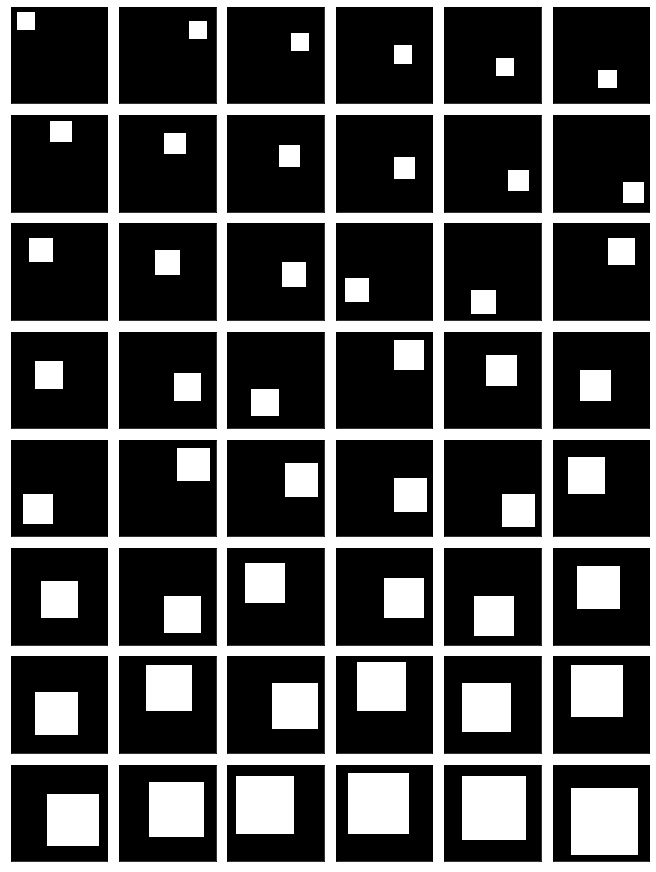


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the fake images]



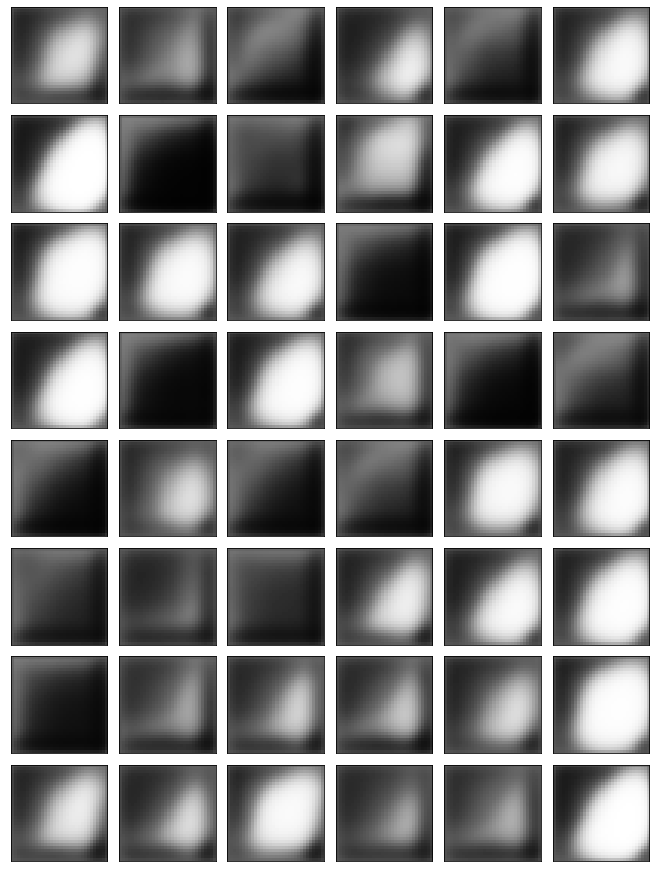


################################################################################
#
# RESULT # 03
#
################################################################################

[plot the generator loss]



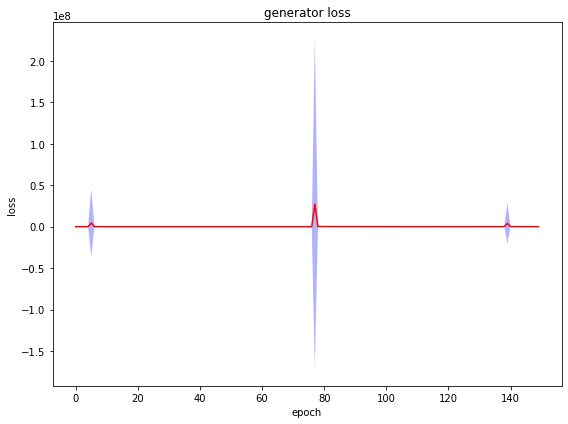


################################################################################
#
# RESULT # 04
#
################################################################################

[plot the discriminator loss]



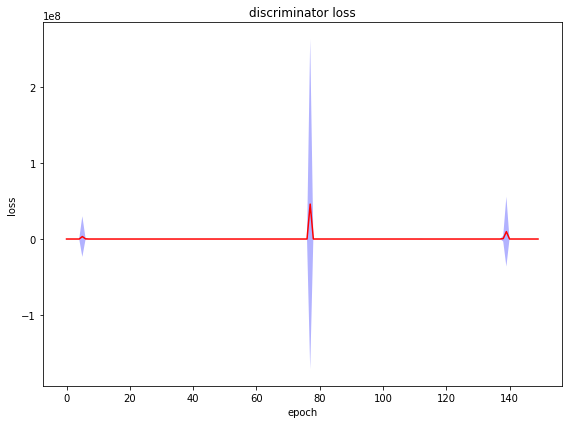


################################################################################
#
# RESULT # 05
#
################################################################################

[plot the accuracy]



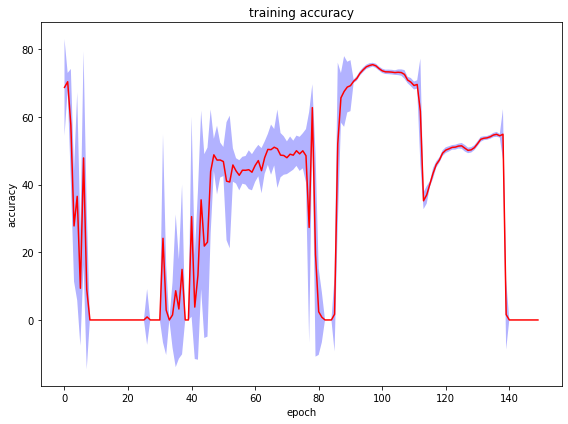


################################################################################
#
# RESULT # 06
#
################################################################################

[print the generator loss at the last 10 epochs]

index =  0, value = 49598.4003947058
index =  1, value = 33777.5290044740
index =  2, value = 30643.9714014807
index =  3, value = 23668.5373498784
index =  4, value = 23419.0948543105
index =  5, value = 19108.4312128466
index =  6, value = 13944.0439304086
index =  7, value = 12054.2066266259
index =  8, value = 8931.2253464544
index =  9, value = 8293.4763928790

################################################################################
#
# RESULT # 07
#
################################################################################

[print the discriminator loss at the last 10 epochs]

index =  0, value = 10408.3146177780
index =  1, value = 4297.3023443887
index =  2, value = 4190.6597879099
index =  3, value = 5049.3415058934
index =  4, value =

In [39]:
number_result = 9

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)